In [1]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(991989)

#LIBRARY TO SPLIT TRAIN AND TEST DATA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

#IMPORTING KERS UTILITIES, LIBRARIES AND MODULES.
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation #, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD, Adam #, RMSprop
from keras.utils import np_utils
from keras import layers
from keras.callbacks import EarlyStopping

#FOR CONFUSION MATRIX AND ACCURACY SCORE CALCULATION
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#FOR PLOTTING MODEL AS FLOWCHARTS
from keras.utils import plot_model
from IPython.display import Image

#USING HYPERAS FOR OPTIMIZATION
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform



Using TensorFlow backend.


### LOADING DATA FROM UCI REPOSITORY DIRECTLY

In [2]:
#LOADING DATA
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data", delimiter = r"\s+",
                header=None )

#EXPLORING DATA
print(df.head())
print(df.shape)

   0    1    2    3    4    5    6    7    8    9    ...  256  257  258  259  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
1  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    1    0    0    0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    1    0    0    0   

   260  261  262  263  264  265  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 266 columns]
(1593, 266)


In [3]:
#LOADING PREDICTORS IN X DATAFRAME
X = pd.DataFrame(df)

#DROPPING TARGET ATTRIBUTES
X = X.drop([256,257,258,259,260,261,262,263,264,265], axis=1)

#EXPLORING PREDICTOR VARIABLES
print(type(X))
print(X.shape)

#LOADING TARGET ATTRIBUTES IN Y DATAFRAME
y = pd.DataFrame(df.iloc[:,[256,257,258,259,260,261,262,263,264,265]])

#RENAMING LABELS OF TARGET ATTRIBUTES
y.rename(columns={256:0, 257:1, 258:2, 259:3, 260:4, 261:5, 262:6, 263:7, 264:8, 265:9 }, inplace=True)

#EXPLORING TARGET VARIABLES
print(y.shape)
print(y.head())

#SPLITTING DATA INTO TRAINING(70%) AND TEST DATA(30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
    
#CONVERTING X AND Y DATAFRAME INTO LIST OF ARRAYS
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

<class 'pandas.core.frame.DataFrame'>
(1593, 256)
(1593, 10)
   0  1  2  3  4  5  6  7  8  9
0  1  0  0  0  0  0  0  0  0  0
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0


### DISPLAYING IMAGE

In [4]:
# Reshape image in 3 dimensions (height = 16px, width = 16px , canal = 1)
X_img = X.values.reshape(-1,16,16,1)

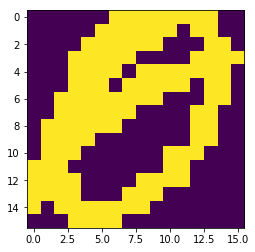

In [5]:
# Displaying image
g = plt.imshow(X_img[0][:,:,0])


In [6]:
#CALCULATING NO. OF ROWS PRESENT IN TEST DATA TO BE USED IN CONFUSION MATRIX
y_testrows = y_test.shape[0]

#Exploring train and test data
print(y_testrows)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

478
(1115, 256)
(1115, 10)
(478, 256)
(478, 10)


In [7]:
#FUNCTION TO GENERATE KERAS SEQUENTIAL MODEL. THIS FUNCTION WILL TAKE TRAIN DATA, TEST DATA, NUMBER OF PARAMETERS,
#INPUT SHAPE, ACTIVATION FUNCTION, LOSS FUNCTION AND OPTIMIZER FUNCTION AS ARGUMENTS

def get_model_main(X_train,y_train, X_test, y_test, input_layer,output_layer,input_shape,activation_func,loss_func,optmzr_func):
    # create model
    print(input_layer)
    model = Sequential()
    model.add(Dense(input_layer, input_shape=(256,), bias_initializer='Ones', activation=activation_func))
    model.add(Dense(output_layer, activation=activation_func, bias_initializer='Ones'))
    
    #CompiLe Model
    model.compile(loss=loss_func, optimizer=optmzr_func, metrics=['accuracy'])
    
    # Fit the model
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50) #batch_size=200, verbose=2
    
    #Plotting Epoch graph
    print(history.history.keys())
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("Baseline Error: %.2f%%" % (100-scores[1]*100))
    return model
    
#FUNCTION TO CREATE CONFUSION MATRIX. WE NEED TO PASS KERAS MODEL, AND TEST DATA TO THIS FUNCTION     
def confusion_function(model,X_test, y_test):                                  
    y_prediction = model.predict(X_test)
    y_pred=[]
    for y in y_prediction:
        temp = np.where(y == y.max(), 1, 0)
        y_pred.append(temp.tolist())
        len(y_pred)
    y_predict_df = pd.DataFrame(np.array(y_pred).reshape(y_testrows,10), columns = list("0123456789"))
    y_predict_df['y_1col'] = y_predict_df.idxmax(axis=1)
    y_pred = y_predict_df['y_1col']

    y_test_df = pd.DataFrame(y_test, columns = list("0123456789"))
    y_test_df['y_testcol'] = y_test_df.idxmax(axis=1)
    y_test = y_test_df['y_testcol']


    cf = confusion_matrix(y_test, y_pred)
    array = cf
    df_cm = pd.DataFrame(array, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
    plt.figure(figsize = (10,7))
    cf_plot = sns.heatmap(df_cm, annot=True)
    return cf_plot

#function to create a plot of the network neural network graph that can make more complex models easier to understand.
def model_plot(model):
    #model plot
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return Image("model.png")



In [8]:
#FUNCTION TO GENERATE KERAS SEQUENTIAL MODEL USING TEST DATA AS VALIDATION DATA. THIS FUNCTION WILL TAKE TRAIN DATA, TEST DATA, NUMBER OF PARAMETERS,
#INPUT SHAPE, ACTIVATION FUNCTION, LOSS FUNCTION AND OPTIMIZER FUNCTION AS ARGUMENTS

def get_model_testdata(X_train,y_train, X_test, y_test, input_layer,output_layer,input_shape,activation_func,loss_func,optmzr_func):
    # create model
    print(input_layer)
    model = Sequential()
    model.add(Dense(input_layer, input_shape=(256,), bias_initializer='Ones', activation=activation_func))
    model.add(Dense(output_layer, activation=activation_func, bias_initializer='Ones'))
    
    #CompiLe Model
    model.compile(loss=loss_func, optimizer=optmzr_func, metrics=['accuracy'])
    
    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50) 


    #Plotting Epoch graph
    print(history.history.keys())
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("Baseline Error: %.2f%%" % (100-scores[1]*100))
    return model

In [9]:
#FUNCTION TO GENERATE KERAS SEQUENTIAL MODEL WHILE CHECKING EPOCH COUNTS. THIS FUNCTION WILL TAKE TRAIN DATA, TEST DATA, NUMBER OF PARAMETERS,
#INPUT SHAPE, ACTIVATION FUNCTION, LOSS FUNCTION AND OPTIMIZER FUNCTION AS ARGUMENTS

def get_model_epochcheck(X_train,y_train, X_test, y_test, input_layer,output_layer,input_shape,activation_func,loss_func,optmzr_func):
    # create model
    print(input_layer)
    model = Sequential()
    model.add(Dense(input_layer, input_shape=(256,), bias_initializer='Ones', activation=activation_func))
    model.add(Dense(output_layer, activation=activation_func, bias_initializer='Ones'))
    
    #CompiLe Model
    model.compile(loss=loss_func, optimizer=optmzr_func, metrics=['accuracy'])
    
    #For stopping optimization when the validation loss hasn't improved for patience epochs. In this case, 2 epochs
    early_stopping_monitor = EarlyStopping(patience=2)
    # Fit the model
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=300,callbacks=[early_stopping_monitor]) #batch_size=200, verbose=2


    #Plotting Epoch graph
    print(history.history.keys())
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    
        # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("Baseline Error: %.2f%%" % (100-scores[1]*100))
    return model

In [10]:
#INPUT_SHAPE : SHAPES ARE CONSEQUENCES OF THE MODEL'S CONFIGURATION.SHAPES ARE BASICALLY TUPLES REPRESENTING 
#HOW MANY ELEMENTS AN ARRAY OR TENSOR HAS IN EACH DIMENSION
input_shape =256

In [11]:
#BACKPROPAGATION WITH SGD AND LEARNING RATE EQUALS TO 0.1.
lr = (0.1)
my_optimizer = SGD(lr=lr)


##### BUILDING MODEL WITH 20 INPUT HIDDEN LAYERS

20
Train on 892 samples, validate on 223 samples
Epoch 1/50
892/892 [==============================] - ETA: 10s - loss: 2.3918 - acc: 0.15 - ETA: 0s - loss: 2.3508 - acc: 0.0827 - 1s 622us/step - loss: 2.3284 - acc: 0.1031 - val_loss: 2.3159 - val_acc: 0.0852
Epoch 2/50
892/892 [==============================] - ETA: 0s - loss: 2.3005 - acc: 0.187 - ETA: 0s - loss: 2.2927 - acc: 0.111 - ETA: 0s - loss: 2.2939 - acc: 0.103 - 0s 147us/step - loss: 2.2921 - acc: 0.1031 - val_loss: 2.2944 - val_acc: 0.0852
Epoch 3/50
892/892 [==============================] - ETA: 0s - loss: 2.2870 - acc: 0.125 - ETA: 0s - loss: 2.2783 - acc: 0.096 - ETA: 0s - loss: 2.2743 - acc: 0.101 - 0s 162us/step - loss: 2.2717 - acc: 0.1031 - val_loss: 2.2783 - val_acc: 0.0852
Epoch 4/50
892/892 [==============================] - ETA: 0s - loss: 2.2717 - acc: 0.031 - ETA: 0s - loss: 2.2614 - acc: 0.083 - 0s 129us/step - loss: 2.2544 - acc: 0.1031 - val_loss: 2.2611 - val_acc: 0.0852
Epoch 5/50
892/892 [==============

892/892 [==============================] - ETA: 0s - loss: 0.4545 - acc: 0.906 - ETA: 0s - loss: 0.4783 - acc: 0.920 - 0s 127us/step - loss: 0.4669 - acc: 0.9238 - val_loss: 0.5344 - val_acc: 0.9238
Epoch 38/50
892/892 [==============================] - ETA: 0s - loss: 0.5272 - acc: 0.906 - ETA: 0s - loss: 0.4541 - acc: 0.922 - 0s 126us/step - loss: 0.4478 - acc: 0.9249 - val_loss: 0.5204 - val_acc: 0.9193
Epoch 39/50
892/892 [==============================] - ETA: 0s - loss: 0.4722 - acc: 0.937 - ETA: 0s - loss: 0.4327 - acc: 0.937 - 0s 128us/step - loss: 0.4316 - acc: 0.9316 - val_loss: 0.5062 - val_acc: 0.9193
Epoch 40/50
892/892 [==============================] - ETA: 0s - loss: 0.4133 - acc: 0.906 - ETA: 0s - loss: 0.4000 - acc: 0.941 - 0s 123us/step - loss: 0.4144 - acc: 0.9316 - val_loss: 0.4927 - val_acc: 0.9148
Epoch 41/50
892/892 [==============================] - ETA: 0s - loss: 0.2900 - acc: 0.968 - ETA: 0s - loss: 0.4068 - acc: 0.928 - 0s 122us/step - loss: 0.3998 - acc: 0

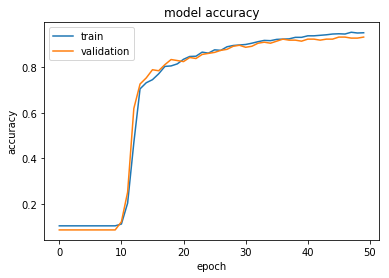

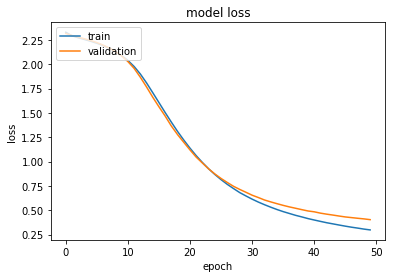

Accuracy: 91.63%
Baseline Error: 8.37%


In [12]:
# BUILDING MODEL WITH 20 INPUT HIDDEN LAYERS
model_n20 = get_model_main(X_train,y_train, X_test, y_test,
                                  input_layer=20,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

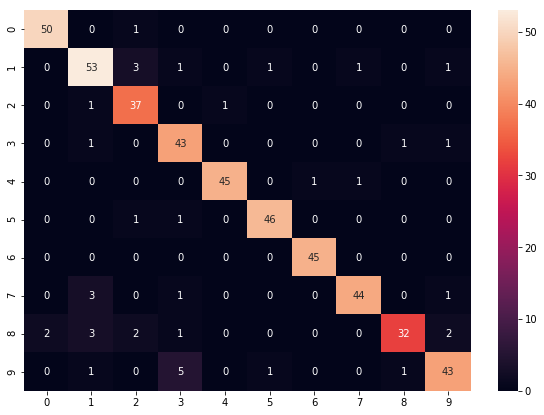

In [13]:
# CONFUSION MATRIX OF MODEL WITH 20 INPUT HIDDEN LAYERS
confusion_function(model_n20,X_test,y_test)

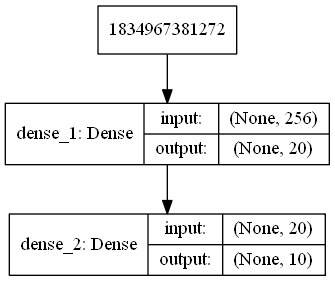

In [14]:
#PLOT OF NEURAL NETWORK GRAPH
model_plot(model_n20)

##### BUILDING MODEL WITH 50 INPUT HIDDEN LAYERS

50
Train on 892 samples, validate on 223 samples
Epoch 1/50
892/892 [==============================] - ETA: 11s - loss: 2.2822 - acc: 0.15 - ETA: 0s - loss: 2.3111 - acc: 0.1116 - 1s 669us/step - loss: 2.3095 - acc: 0.1076 - val_loss: 2.2895 - val_acc: 0.0897
Epoch 2/50
892/892 [==============================] - ETA: 0s - loss: 2.2650 - acc: 0.125 - ETA: 0s - loss: 2.2714 - acc: 0.109 - ETA: 0s - loss: 2.2755 - acc: 0.110 - 0s 148us/step - loss: 2.2772 - acc: 0.1076 - val_loss: 2.2697 - val_acc: 0.0897
Epoch 3/50
892/892 [==============================] - ETA: 0s - loss: 2.2350 - acc: 0.156 - ETA: 0s - loss: 2.2616 - acc: 0.104 - ETA: 0s - loss: 2.2553 - acc: 0.111 - 0s 148us/step - loss: 2.2562 - acc: 0.1076 - val_loss: 2.2489 - val_acc: 0.0897
Epoch 4/50
892/892 [==============================] - ETA: 0s - loss: 2.2502 - acc: 0.062 - ETA: 0s - loss: 2.2302 - acc: 0.118 - ETA: 0s - loss: 2.2264 - acc: 0.117 - 0s 157us/step - loss: 2.2273 - acc: 0.1076 - val_loss: 2.2147 - val_acc: 0.0

Epoch 37/50
892/892 [==============================] - ETA: 0s - loss: 0.3571 - acc: 0.906 - ETA: 0s - loss: 0.2514 - acc: 0.960 - 0s 128us/step - loss: 0.2484 - acc: 0.9619 - val_loss: 0.3620 - val_acc: 0.9372
Epoch 38/50
892/892 [==============================] - ETA: 0s - loss: 0.2759 - acc: 0.937 - ETA: 0s - loss: 0.2413 - acc: 0.960 - ETA: 0s - loss: 0.2413 - acc: 0.965 - 0s 146us/step - loss: 0.2392 - acc: 0.9652 - val_loss: 0.3558 - val_acc: 0.9372
Epoch 39/50
892/892 [==============================] - ETA: 0s - loss: 0.1821 - acc: 1.000 - ETA: 0s - loss: 0.2392 - acc: 0.962 - 0s 125us/step - loss: 0.2307 - acc: 0.9641 - val_loss: 0.3498 - val_acc: 0.9372
Epoch 40/50
892/892 [==============================] - ETA: 0s - loss: 0.2260 - acc: 1.000 - ETA: 0s - loss: 0.2128 - acc: 0.972 - 0s 130us/step - loss: 0.2236 - acc: 0.9686 - val_loss: 0.3457 - val_acc: 0.9327
Epoch 41/50
892/892 [==============================] - ETA: 0s - loss: 0.3654 - acc: 0.937 - ETA: 0s - loss: 0.2252 - 

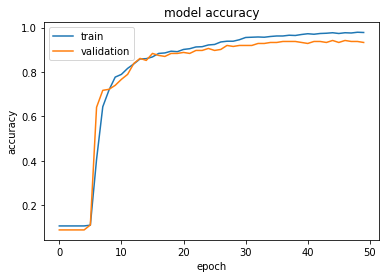

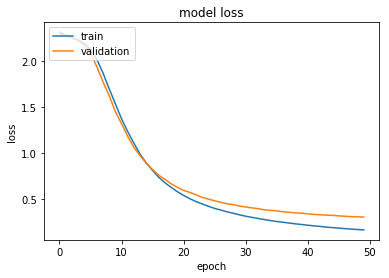

Accuracy: 91.00%
Baseline Error: 9.00%


In [15]:
# BUILDING MODEL WITH 50 INPUT HIDDEN LAYERS
model_n50 = get_model_main(X_train,y_train, X_test, y_test,
                                  input_layer=50,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

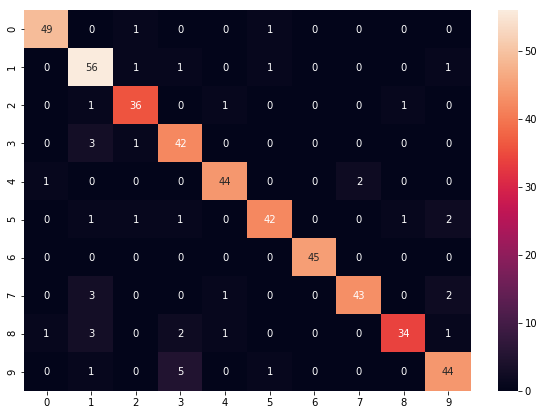

In [16]:
# CONFUSION MATRIX OF MODEL WITH 50 INPUT HIDDEN LAYERS
confusion_function(model_n50,X_test,y_test)

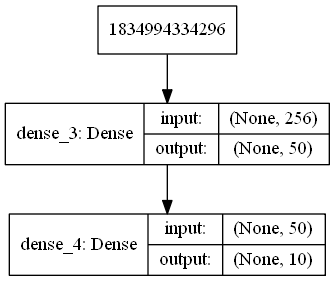

In [17]:
#PLOT OF NEURAL NETWORK GRAPH
model_plot(model_n50)

##### BUILDING MODEL WITH 100 INPUT HIDDEN LAYERS

100
Train on 892 samples, validate on 223 samples
Epoch 1/50
892/892 [==============================] - ETA: 13s - loss: 2.3304 - acc: 0.03 - ETA: 0s - loss: 2.3231 - acc: 0.0881 - ETA: 0s - loss: 2.3125 - acc: 0.098 - 1s 856us/step - loss: 2.3067 - acc: 0.1020 - val_loss: 2.2935 - val_acc: 0.1076
Epoch 2/50
892/892 [==============================] - ETA: 0s - loss: 2.2529 - acc: 0.125 - ETA: 0s - loss: 2.2799 - acc: 0.176 - ETA: 0s - loss: 2.2738 - acc: 0.177 - 0s 159us/step - loss: 2.2736 - acc: 0.1760 - val_loss: 2.2662 - val_acc: 0.1435
Epoch 3/50
892/892 [==============================] - ETA: 0s - loss: 2.2537 - acc: 0.187 - ETA: 0s - loss: 2.2467 - acc: 0.259 - ETA: 0s - loss: 2.2402 - acc: 0.246 - 0s 157us/step - loss: 2.2365 - acc: 0.2578 - val_loss: 2.2185 - val_acc: 0.2287
Epoch 4/50
892/892 [==============================] - ETA: 0s - loss: 2.1913 - acc: 0.343 - ETA: 0s - loss: 2.1905 - acc: 0.264 - ETA: 0s - loss: 2.1633 - acc: 0.310 - 0s 153us/step - loss: 2.1580 - acc: 0

892/892 [==============================] - ETA: 0s - loss: 0.2970 - acc: 0.906 - ETA: 0s - loss: 0.2147 - acc: 0.971 - ETA: 0s - loss: 0.2257 - acc: 0.963 - 0s 157us/step - loss: 0.2227 - acc: 0.9652 - val_loss: 0.3416 - val_acc: 0.9148
Epoch 35/50
892/892 [==============================] - ETA: 0s - loss: 0.1195 - acc: 1.000 - ETA: 0s - loss: 0.2030 - acc: 0.971 - ETA: 0s - loss: 0.2142 - acc: 0.966 - 0s 156us/step - loss: 0.2152 - acc: 0.9652 - val_loss: 0.3262 - val_acc: 0.9103
Epoch 36/50
892/892 [==============================] - ETA: 0s - loss: 0.1508 - acc: 1.000 - ETA: 0s - loss: 0.2130 - acc: 0.963 - ETA: 0s - loss: 0.2122 - acc: 0.970 - 0s 158us/step - loss: 0.2082 - acc: 0.9697 - val_loss: 0.3210 - val_acc: 0.9148
Epoch 37/50
892/892 [==============================] - ETA: 0s - loss: 0.2211 - acc: 0.937 - ETA: 0s - loss: 0.1915 - acc: 0.974 - 0s 143us/step - loss: 0.2005 - acc: 0.9720 - val_loss: 0.3195 - val_acc: 0.9058
Epoch 38/50
892/892 [==============================] -

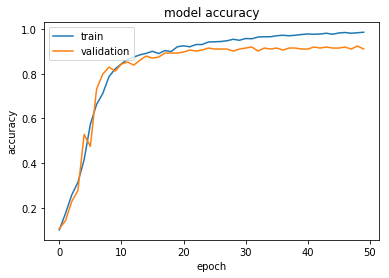

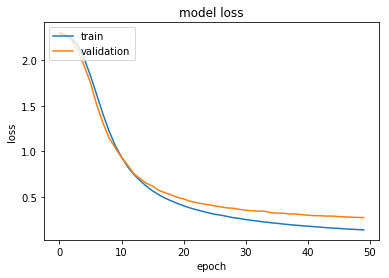

Accuracy: 91.84%
Baseline Error: 8.16%


In [18]:
# BUILDING MODEL WITH 100 INPUT HIDDEN LAYERS
model_n100 = get_model_main(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

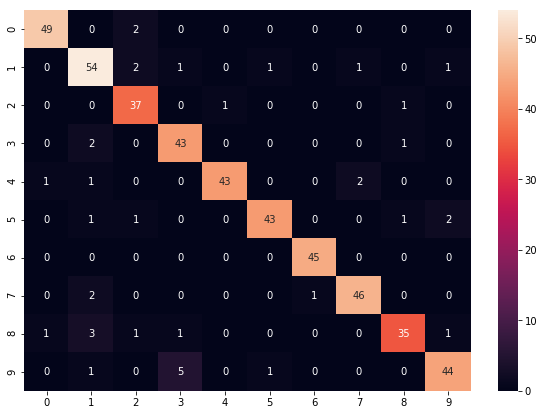

In [19]:
# CONFUSION MATRIX OF MODEL WITH 100 INPUT HIDDEN LAYERS
confusion_function(model_n100,X_test,y_test)

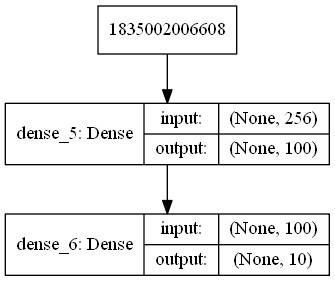

In [20]:
#PLOT OF NEURAL NETWORK GRAPH
model_plot(model_n100)

##### 1a. Conduct experiments with n = 20, 50 and 100. (Hint: remember to include bias unit weights). Train your network for 50 epochs. After each epoch, record your accuracy on training set AND test set for your network. After training is complete, create a confusion matrix for each of your trained networks, summarizing results on the test set.

Answer:
 After splitting the data into into training(70%) and test data(30%), I am running the model using function get_model_main() that I created.This model will further split the train data into train and validation data(0.2 of the training data). I am not using test data to fit my model because it will cause data leakage issue. 
 
 1. Setting input layer equals to 20 , we get test accuracy of 91.63%. After creating confusion matrix, I found that few digits such as digits 8,7 were falsely predicted as 1 , digit 9 was falsely predicted as 3.
 2. Setting input layer equals to 20 , we get test accuracy of 91%. After creating confusion matrix, I found that few digits such as digit 9 was falsely predicted as 3 while digits 8,7 were falsely predicted as 1 .
 3. Setting input layer equals to 20 , we get test accuracy of 91.84%. After creating confusion matrix, I found that few digits such as digit 9 was falsely predicted as 3.


##### 1b. Give a plot of both training and test accuracy as a function of epoch number
(graph both of these on sample plot).


Answer: 
Since this question asks to plot training and test data accuracies as function of epoch number, I created another function get_model_testdata() which uses test data as validation data and it will plot epoch graphs for hidden layers equals to 20,50 and 100 respectively.

##### BUILDING MODEL WITH TEST DATA USING 20 INPUT HIDDEN LAYERS

20
Train on 1115 samples, validate on 478 samples
Epoch 1/50
1115/1115 [==============================] - ETA: 17s - loss: 2.3400 - acc: 0.03 - ETA: 0s - loss: 2.3275 - acc: 0.1116 - ETA: 0s - loss: 2.3192 - acc: 0.100 - 1s 674us/step - loss: 2.3179 - acc: 0.0960 - val_loss: 2.2977 - val_acc: 0.1067
Epoch 2/50
1115/1115 [==============================] - ETA: 0s - loss: 2.3114 - acc: 0.093 - ETA: 0s - loss: 2.2947 - acc: 0.101 - ETA: 0s - loss: 2.2897 - acc: 0.107 - 0s 147us/step - loss: 2.2928 - acc: 0.0960 - val_loss: 2.2810 - val_acc: 0.1067
Epoch 3/50
1115/1115 [==============================] - ETA: 0s - loss: 2.3131 - acc: 0.031 - ETA: 0s - loss: 2.2786 - acc: 0.082 - ETA: 0s - loss: 2.2759 - acc: 0.099 - 0s 144us/step - loss: 2.2752 - acc: 0.0969 - val_loss: 2.2653 - val_acc: 0.1067
Epoch 4/50
1115/1115 [==============================] - ETA: 0s - loss: 2.2470 - acc: 0.156 - ETA: 0s - loss: 2.2531 - acc: 0.101 - ETA: 0s - loss: 2.2574 - acc: 0.094 - 0s 150us/step - loss: 2.2573 

1115/1115 [==============================] - ETA: 0s - loss: 0.3735 - acc: 0.937 - ETA: 0s - loss: 0.4187 - acc: 0.927 - ETA: 0s - loss: 0.4030 - acc: 0.931 - 0s 152us/step - loss: 0.3977 - acc: 0.9291 - val_loss: 0.4582 - val_acc: 0.8975
Epoch 34/50
1115/1115 [==============================] - ETA: 0s - loss: 0.4656 - acc: 0.843 - ETA: 0s - loss: 0.3837 - acc: 0.932 - ETA: 0s - loss: 0.3788 - acc: 0.931 - 0s 129us/step - loss: 0.3811 - acc: 0.9309 - val_loss: 0.4440 - val_acc: 0.8996
Epoch 35/50
1115/1115 [==============================] - ETA: 0s - loss: 0.3384 - acc: 0.968 - ETA: 0s - loss: 0.3948 - acc: 0.920 - 0s 112us/step - loss: 0.3639 - acc: 0.9327 - val_loss: 0.4340 - val_acc: 0.9038
Epoch 36/50
1115/1115 [==============================] - ETA: 0s - loss: 0.2493 - acc: 1.000 - ETA: 0s - loss: 0.3256 - acc: 0.953 - ETA: 0s - loss: 0.3459 - acc: 0.941 - 0s 136us/step - loss: 0.3492 - acc: 0.9390 - val_loss: 0.4238 - val_acc: 0.9059
Epoch 37/50
1115/1115 [=======================

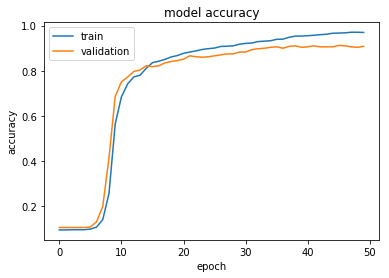

Accuracy: 90.79%
Baseline Error: 9.21%


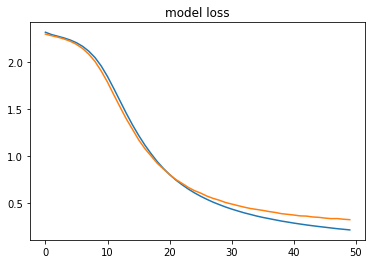

In [21]:
# BUILDING MODEL WITH TEST DATA USING 20 INPUT HIDDEN LAYERS
model_ntest20 = get_model_testdata(X_train,y_train, X_test, y_test,
                                  input_layer=20,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

50
Train on 1115 samples, validate on 478 samples
Epoch 1/50
1115/1115 [==============================] - ETA: 16s - loss: 2.3606 - acc: 0.15 - ETA: 0s - loss: 2.3081 - acc: 0.1172 - ETA: 0s - loss: 2.3035 - acc: 0.105 - 1s 653us/step - loss: 2.3029 - acc: 0.1022 - val_loss: 2.2874 - val_acc: 0.0983
Epoch 2/50
1115/1115 [==============================] - ETA: 0s - loss: 2.2949 - acc: 0.093 - ETA: 0s - loss: 2.2782 - acc: 0.100 - ETA: 0s - loss: 2.2752 - acc: 0.107 - 0s 151us/step - loss: 2.2745 - acc: 0.1022 - val_loss: 2.2651 - val_acc: 0.0983
Epoch 3/50
1115/1115 [==============================] - ETA: 0s - loss: 2.2646 - acc: 0.093 - ETA: 0s - loss: 2.2570 - acc: 0.089 - ETA: 0s - loss: 2.2500 - acc: 0.101 - 0s 148us/step - loss: 2.2463 - acc: 0.1022 - val_loss: 2.2357 - val_acc: 0.0983
Epoch 4/50
1115/1115 [==============================] - ETA: 0s - loss: 2.2085 - acc: 0.187 - ETA: 0s - loss: 2.2128 - acc: 0.112 - ETA: 0s - loss: 2.2070 - acc: 0.106 - 0s 145us/step - loss: 2.2017 

1115/1115 [==============================] - ETA: 0s - loss: 0.1997 - acc: 1.000 - ETA: 0s - loss: 0.2204 - acc: 0.970 - ETA: 0s - loss: 0.2241 - acc: 0.965 - 0s 151us/step - loss: 0.2315 - acc: 0.9605 - val_loss: 0.3184 - val_acc: 0.9100
Epoch 34/50
1115/1115 [==============================] - ETA: 0s - loss: 0.2824 - acc: 0.937 - ETA: 0s - loss: 0.2157 - acc: 0.968 - ETA: 0s - loss: 0.2175 - acc: 0.971 - 0s 148us/step - loss: 0.2229 - acc: 0.9686 - val_loss: 0.3109 - val_acc: 0.9142
Epoch 35/50
1115/1115 [==============================] - ETA: 0s - loss: 0.1609 - acc: 0.968 - ETA: 0s - loss: 0.1822 - acc: 0.979 - ETA: 0s - loss: 0.2017 - acc: 0.978 - 0s 149us/step - loss: 0.2152 - acc: 0.9686 - val_loss: 0.3055 - val_acc: 0.9163
Epoch 36/50
1115/1115 [==============================] - ETA: 0s - loss: 0.2214 - acc: 0.968 - ETA: 0s - loss: 0.2333 - acc: 0.959 - ETA: 0s - loss: 0.2189 - acc: 0.967 - 0s 158us/step - loss: 0.2082 - acc: 0.9695 - val_loss: 0.2976 - val_acc: 0.9184
Epoch 37

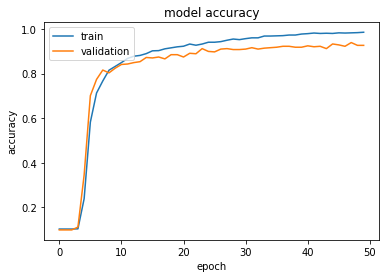

Accuracy: 92.68%
Baseline Error: 7.32%


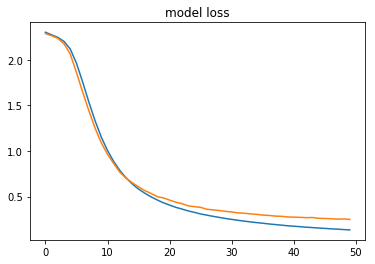

In [22]:
# BUILDING MODEL WITH TEST DATA USING 50 INPUT HIDDEN LAYERS
model_ntest50 = get_model_testdata(X_train,y_train, X_test, y_test,
                                  input_layer=50,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

100
Train on 1115 samples, validate on 478 samples
Epoch 1/50
1115/1115 [==============================] - ETA: 18s - loss: 2.3577 - acc: 0.0000e+ - ETA: 0s - loss: 2.3271 - acc: 0.0804     - ETA: 0s - loss: 2.3211 - acc: 0.096 - 1s 723us/step - loss: 2.3152 - acc: 0.0915 - val_loss: 2.2902 - val_acc: 0.1255
Epoch 2/50
1115/1115 [==============================] - ETA: 0s - loss: 2.2850 - acc: 0.062 - ETA: 0s - loss: 2.2940 - acc: 0.084 - ETA: 0s - loss: 2.2923 - acc: 0.082 - 0s 165us/step - loss: 2.2873 - acc: 0.0915 - val_loss: 2.2707 - val_acc: 0.1255
Epoch 3/50
1115/1115 [==============================] - ETA: 0s - loss: 2.2433 - acc: 0.187 - ETA: 0s - loss: 2.2700 - acc: 0.098 - ETA: 0s - loss: 2.2663 - acc: 0.098 - 0s 157us/step - loss: 2.2640 - acc: 0.0915 - val_loss: 2.2400 - val_acc: 0.1255
Epoch 4/50
1115/1115 [==============================] - ETA: 0s - loss: 2.2495 - acc: 0.0000e+0 - ETA: 0s - loss: 2.2368 - acc: 0.0871    - ETA: 0s - loss: 2.2316 - acc: 0.085 - 0s 159us/ste

1115/1115 [==============================] - ETA: 0s - loss: 0.2360 - acc: 0.937 - ETA: 0s - loss: 0.1806 - acc: 0.971 - ETA: 0s - loss: 0.1922 - acc: 0.970 - 0s 161us/step - loss: 0.1961 - acc: 0.9686 - val_loss: 0.2834 - val_acc: 0.9247
Epoch 34/50
1115/1115 [==============================] - ETA: 0s - loss: 0.1999 - acc: 0.968 - ETA: 0s - loss: 0.1870 - acc: 0.977 - ETA: 0s - loss: 0.1883 - acc: 0.971 - 0s 159us/step - loss: 0.1890 - acc: 0.9686 - val_loss: 0.2822 - val_acc: 0.9205
Epoch 35/50
1115/1115 [==============================] - ETA: 0s - loss: 0.1508 - acc: 0.968 - ETA: 0s - loss: 0.1787 - acc: 0.966 - ETA: 0s - loss: 0.1871 - acc: 0.966 - 0s 157us/step - loss: 0.1827 - acc: 0.9695 - val_loss: 0.2731 - val_acc: 0.9247
Epoch 36/50
1115/1115 [==============================] - ETA: 0s - loss: 0.2184 - acc: 0.937 - ETA: 0s - loss: 0.1502 - acc: 0.973 - ETA: 0s - loss: 0.1744 - acc: 0.967 - 0s 160us/step - loss: 0.1767 - acc: 0.9695 - val_loss: 0.2803 - val_acc: 0.9226
Epoch 37

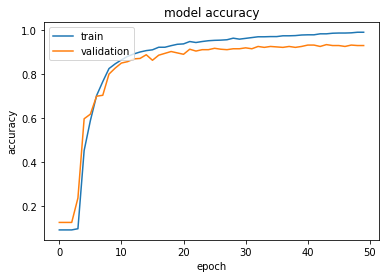

Accuracy: 92.89%
Baseline Error: 7.11%


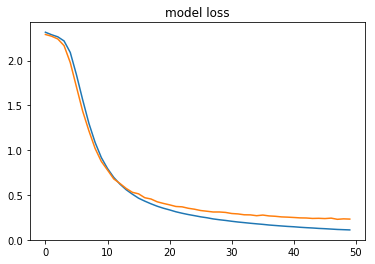

In [23]:
#BUILDING MODEL WITH TEST DATA USING 100 INPUT HIDDEN LAYERS
model_ntest100 = get_model_testdata(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

##### 1c. Discuss your results. How does number of hidden units affect the final accuracy on the test data?

Answer:

As we can see from above,when we increase number of hidden layers, accuracy does increase eachtime. Having said that,we also have to keep tab on  how much are we increasing hidden layers. Accuracy improves until a certain point or threshold and then it starts to decrease . 

##### 1d. Discuss your results. How does number of hidden units affect number of epochs needed for training to converge?

Answer: We can check this by understanding epoch graphs of different models we plotted above. As we can see from the graph, when we increase number of hidden layers, the line of epoch graph becomes straight line almost parallel to x-axis early. This means that it becomes straight line in less number of epochs. So, increasing hidden layer decreases number of epochs.

I also created function to check no. of epochs needed with different hidden layers. For this, I gave hidden layers =300 and set early stopping criteria with patience =2.

After running above function for different number of hidden layers, we found that epochs count decreases when we increase hidden units

20
Train on 892 samples, validate on 223 samples
Epoch 1/300
892/892 [==============================] - ETA: 15s - loss: 2.3088 - acc: 0.25 - ETA: 0s - loss: 2.3126 - acc: 0.1328 - 1s 850us/step - loss: 2.3058 - acc: 0.1457 - val_loss: 2.2977 - val_acc: 0.1166
Epoch 2/300
892/892 [==============================] - ETA: 0s - loss: 2.2966 - acc: 0.187 - ETA: 0s - loss: 2.2929 - acc: 0.131 - 0s 125us/step - loss: 2.2830 - acc: 0.1491 - val_loss: 2.2796 - val_acc: 0.1211
Epoch 3/300
892/892 [==============================] - ETA: 0s - loss: 2.2753 - acc: 0.031 - ETA: 0s - loss: 2.2704 - acc: 0.145 - 0s 132us/step - loss: 2.2639 - acc: 0.1603 - val_loss: 2.2607 - val_acc: 0.1211
Epoch 4/300
892/892 [==============================] - ETA: 0s - loss: 2.2578 - acc: 0.093 - ETA: 0s - loss: 2.2486 - acc: 0.166 - 0s 124us/step - loss: 2.2432 - acc: 0.1783 - val_loss: 2.2387 - val_acc: 0.1480
Epoch 5/300
892/892 [==============================] - ETA: 0s - loss: 2.2334 - acc: 0.156 - ETA: 0s - los

Epoch 39/300
892/892 [==============================] - ETA: 0s - loss: 0.3733 - acc: 0.968 - ETA: 0s - loss: 0.3826 - acc: 0.954 - ETA: 0s - loss: 0.3896 - acc: 0.949 - 0s 159us/step - loss: 0.3896 - acc: 0.9484 - val_loss: 0.4935 - val_acc: 0.8924
Epoch 40/300
892/892 [==============================] - ETA: 0s - loss: 0.3234 - acc: 1.000 - ETA: 0s - loss: 0.3856 - acc: 0.957 - ETA: 0s - loss: 0.3759 - acc: 0.953 - 0s 185us/step - loss: 0.3748 - acc: 0.9529 - val_loss: 0.4819 - val_acc: 0.8969
Epoch 41/300
892/892 [==============================] - ETA: 0s - loss: 0.4720 - acc: 0.875 - ETA: 0s - loss: 0.3664 - acc: 0.943 - 0s 132us/step - loss: 0.3605 - acc: 0.9507 - val_loss: 0.4710 - val_acc: 0.9013
Epoch 42/300
892/892 [==============================] - ETA: 0s - loss: 0.4701 - acc: 0.937 - ETA: 0s - loss: 0.3518 - acc: 0.947 - ETA: 0s - loss: 0.3514 - acc: 0.953 - 0s 153us/step - loss: 0.3483 - acc: 0.9552 - val_loss: 0.4612 - val_acc: 0.8924
Epoch 43/300
892/892 [================

Epoch 73/300
892/892 [==============================] - ETA: 0s - loss: 0.1658 - acc: 1.000 - ETA: 0s - loss: 0.1446 - acc: 0.993 - ETA: 0s - loss: 0.1475 - acc: 0.995 - 0s 144us/step - loss: 0.1498 - acc: 0.9944 - val_loss: 0.3216 - val_acc: 0.9193
Epoch 74/300
892/892 [==============================] - ETA: 0s - loss: 0.1317 - acc: 1.000 - ETA: 0s - loss: 0.1376 - acc: 0.995 - 0s 136us/step - loss: 0.1465 - acc: 0.9944 - val_loss: 0.3201 - val_acc: 0.9148
Epoch 75/300
892/892 [==============================] - ETA: 0s - loss: 0.1299 - acc: 1.000 - ETA: 0s - loss: 0.1355 - acc: 0.997 - ETA: 0s - loss: 0.1431 - acc: 0.994 - 0s 151us/step - loss: 0.1436 - acc: 0.9944 - val_loss: 0.3179 - val_acc: 0.9148
Epoch 76/300
892/892 [==============================] - ETA: 0s - loss: 0.1795 - acc: 1.000 - ETA: 0s - loss: 0.1473 - acc: 0.997 - ETA: 0s - loss: 0.1432 - acc: 0.993 - 0s 169us/step - loss: 0.1407 - acc: 0.9944 - val_loss: 0.3158 - val_acc: 0.9193
Epoch 77/300
892/892 [================

Epoch 110/300
892/892 [==============================] - ETA: 0s - loss: 0.0709 - acc: 1.000 - ETA: 0s - loss: 0.0784 - acc: 0.997 - 0s 130us/step - loss: 0.0801 - acc: 0.9966 - val_loss: 0.2806 - val_acc: 0.9148
Epoch 111/300
892/892 [==============================] - ETA: 0s - loss: 0.0812 - acc: 1.000 - ETA: 0s - loss: 0.0787 - acc: 0.997 - ETA: 0s - loss: 0.0793 - acc: 0.996 - 0s 154us/step - loss: 0.0788 - acc: 0.9966 - val_loss: 0.2802 - val_acc: 0.9148
Epoch 112/300
892/892 [==============================] - ETA: 0s - loss: 0.1003 - acc: 1.000 - ETA: 0s - loss: 0.0695 - acc: 0.997 - ETA: 0s - loss: 0.0769 - acc: 0.997 - 0s 154us/step - loss: 0.0778 - acc: 0.9966 - val_loss: 0.2792 - val_acc: 0.9193
Epoch 113/300
892/892 [==============================] - ETA: 0s - loss: 0.0606 - acc: 1.000 - ETA: 0s - loss: 0.0804 - acc: 0.995 - ETA: 0s - loss: 0.0783 - acc: 0.996 - 0s 150us/step - loss: 0.0768 - acc: 0.9966 - val_loss: 0.2793 - val_acc: 0.9103
Epoch 114/300
892/892 [===========

Epoch 146/300
892/892 [==============================] - ETA: 0s - loss: 0.0554 - acc: 1.000 - ETA: 0s - loss: 0.0485 - acc: 1.000 - ETA: 0s - loss: 0.0523 - acc: 0.997 - 0s 149us/step - loss: 0.0517 - acc: 0.9978 - val_loss: 0.2676 - val_acc: 0.9148
Epoch 147/300
892/892 [==============================] - ETA: 0s - loss: 0.0465 - acc: 1.000 - ETA: 0s - loss: 0.0497 - acc: 0.997 - ETA: 0s - loss: 0.0510 - acc: 0.997 - 0s 163us/step - loss: 0.0512 - acc: 0.9978 - val_loss: 0.2676 - val_acc: 0.9148
Epoch 148/300
892/892 [==============================] - ETA: 0s - loss: 0.0392 - acc: 1.000 - ETA: 0s - loss: 0.0484 - acc: 0.997 - ETA: 0s - loss: 0.0516 - acc: 0.997 - 0s 166us/step - loss: 0.0507 - acc: 0.9978 - val_loss: 0.2672 - val_acc: 0.9148
Epoch 149/300
892/892 [==============================] - ETA: 0s - loss: 0.0406 - acc: 1.000 - ETA: 0s - loss: 0.0527 - acc: 0.995 - ETA: 0s - loss: 0.0498 - acc: 0.997 - 0s 157us/step - loss: 0.0502 - acc: 0.9978 - val_loss: 0.2668 - val_acc: 0.9

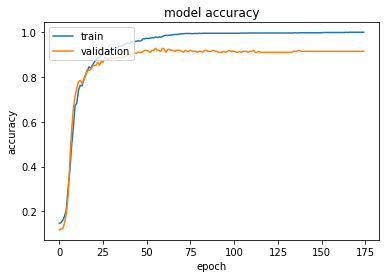

Accuracy: 91.42%
Baseline Error: 8.58%


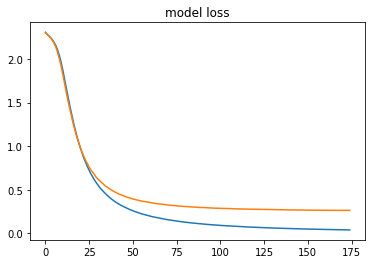

In [24]:
# BUILDING MODEL WITH 20 INPUT HIDDEN LAYERS EPOCH COUNT
model_epochcount20 = get_model_epochcheck(X_train,y_train, X_test, y_test,
                                  input_layer=20,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

#### EPOCH = 175( hidden layers=20)

50
Train on 892 samples, validate on 223 samples
Epoch 1/300
892/892 [==============================] - ETA: 17s - loss: 2.2911 - acc: 0.18 - ETA: 0s - loss: 2.3197 - acc: 0.1183 - ETA: 0s - loss: 2.3060 - acc: 0.116 - 1s 992us/step - loss: 2.3042 - acc: 0.1166 - val_loss: 2.2789 - val_acc: 0.1300
Epoch 2/300
892/892 [==============================] - ETA: 0s - loss: 2.3024 - acc: 0.156 - ETA: 0s - loss: 2.2776 - acc: 0.174 - ETA: 0s - loss: 2.2648 - acc: 0.206 - 0s 160us/step - loss: 2.2640 - acc: 0.2040 - val_loss: 2.2506 - val_acc: 0.2197
Epoch 3/300
892/892 [==============================] - ETA: 0s - loss: 2.2428 - acc: 0.281 - ETA: 0s - loss: 2.2247 - acc: 0.272 - ETA: 0s - loss: 2.2271 - acc: 0.259 - 0s 159us/step - loss: 2.2235 - acc: 0.2724 - val_loss: 2.2029 - val_acc: 0.2870
Epoch 4/300
892/892 [==============================] - ETA: 0s - loss: 2.2075 - acc: 0.250 - ETA: 0s - loss: 2.1883 - acc: 0.346 - ETA: 0s - loss: 2.1713 - acc: 0.372 - 0s 157us/step - loss: 2.1638 - acc

Epoch 34/300
892/892 [==============================] - ETA: 0s - loss: 0.1915 - acc: 1.000 - ETA: 0s - loss: 0.2616 - acc: 0.968 - ETA: 0s - loss: 0.2614 - acc: 0.960 - 0s 161us/step - loss: 0.2599 - acc: 0.9608 - val_loss: 0.3699 - val_acc: 0.9283
Epoch 35/300
892/892 [==============================] - ETA: 0s - loss: 0.2423 - acc: 0.937 - ETA: 0s - loss: 0.2489 - acc: 0.963 - ETA: 0s - loss: 0.2561 - acc: 0.962 - 0s 154us/step - loss: 0.2511 - acc: 0.9641 - val_loss: 0.3608 - val_acc: 0.9283
Epoch 36/300
892/892 [==============================] - ETA: 0s - loss: 0.2269 - acc: 0.968 - ETA: 0s - loss: 0.2547 - acc: 0.959 - ETA: 0s - loss: 0.2468 - acc: 0.960 - 0s 161us/step - loss: 0.2420 - acc: 0.9641 - val_loss: 0.3565 - val_acc: 0.9238
Epoch 37/300
892/892 [==============================] - ETA: 0s - loss: 0.2212 - acc: 0.937 - ETA: 0s - loss: 0.2587 - acc: 0.953 - ETA: 0s - loss: 0.2336 - acc: 0.965 - 0s 155us/step - loss: 0.2344 - acc: 0.9652 - val_loss: 0.3508 - val_acc: 0.9193


Epoch 67/300
892/892 [==============================] - ETA: 0s - loss: 0.0992 - acc: 1.000 - ETA: 0s - loss: 0.1045 - acc: 0.997 - ETA: 0s - loss: 0.1045 - acc: 0.996 - 0s 157us/step - loss: 0.1045 - acc: 0.9966 - val_loss: 0.2653 - val_acc: 0.9327
Epoch 68/300
892/892 [==============================] - ETA: 0s - loss: 0.1002 - acc: 1.000 - ETA: 0s - loss: 0.1074 - acc: 0.995 - ETA: 0s - loss: 0.1044 - acc: 0.994 - 0s 155us/step - loss: 0.1027 - acc: 0.9944 - val_loss: 0.2631 - val_acc: 0.9327
Epoch 69/300
892/892 [==============================] - ETA: 0s - loss: 0.0873 - acc: 1.000 - ETA: 0s - loss: 0.1012 - acc: 0.997 - ETA: 0s - loss: 0.1026 - acc: 0.996 - 0s 162us/step - loss: 0.1004 - acc: 0.9966 - val_loss: 0.2624 - val_acc: 0.9327
Epoch 70/300
892/892 [==============================] - ETA: 0s - loss: 0.1128 - acc: 1.000 - ETA: 0s - loss: 0.0926 - acc: 0.997 - ETA: 0s - loss: 0.0979 - acc: 0.997 - 0s 160us/step - loss: 0.0985 - acc: 0.9978 - val_loss: 0.2624 - val_acc: 0.9327


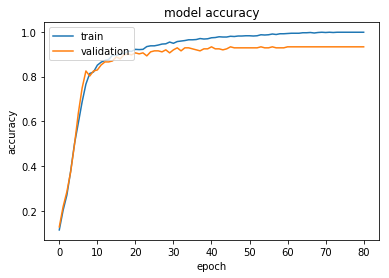

Accuracy: 92.47%
Baseline Error: 7.53%


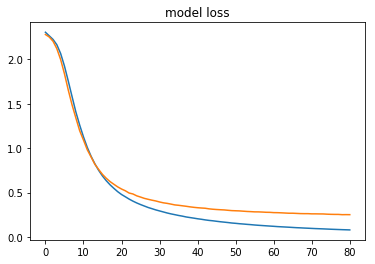

In [25]:
# BUILDING MODEL WITH 50 INPUT HIDDEN LAYERS FOR EPOCH COUNT
model_epochcount50 = get_model_epochcheck(X_train,y_train, X_test, y_test,
                                  input_layer=50,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

#### EPOCH = 81( hidden layer=50)

100
Train on 892 samples, validate on 223 samples
Epoch 1/300
892/892 [==============================] - ETA: 16s - loss: 2.3467 - acc: 0.09 - ETA: 0s - loss: 2.3210 - acc: 0.1027 - ETA: 0s - loss: 2.3103 - acc: 0.098 - 1s 984us/step - loss: 2.3092 - acc: 0.0964 - val_loss: 2.2916 - val_acc: 0.0762
Epoch 2/300
892/892 [==============================] - ETA: 0s - loss: 2.2795 - acc: 0.062 - ETA: 0s - loss: 2.2728 - acc: 0.125 - ETA: 0s - loss: 2.2701 - acc: 0.137 - 0s 166us/step - loss: 2.2690 - acc: 0.1368 - val_loss: 2.2609 - val_acc: 0.1345
Epoch 3/300
892/892 [==============================] - ETA: 0s - loss: 2.2399 - acc: 0.218 - ETA: 0s - loss: 2.2462 - acc: 0.173 - ETA: 0s - loss: 2.2306 - acc: 0.232 - 0s 158us/step - loss: 2.2301 - acc: 0.2309 - val_loss: 2.1927 - val_acc: 0.3677
Epoch 4/300
892/892 [==============================] - ETA: 0s - loss: 2.1796 - acc: 0.343 - ETA: 0s - loss: 2.1752 - acc: 0.312 - ETA: 0s - loss: 2.1517 - acc: 0.362 - 0s 164us/step - loss: 2.1444 - ac

Epoch 34/300
892/892 [==============================] - ETA: 0s - loss: 0.1765 - acc: 0.968 - ETA: 0s - loss: 0.2257 - acc: 0.956 - ETA: 0s - loss: 0.2199 - acc: 0.962 - 0s 163us/step - loss: 0.2203 - acc: 0.9630 - val_loss: 0.3327 - val_acc: 0.9193
Epoch 35/300
892/892 [==============================] - ETA: 0s - loss: 0.1766 - acc: 1.000 - ETA: 0s - loss: 0.2103 - acc: 0.971 - ETA: 0s - loss: 0.2187 - acc: 0.968 - 0s 161us/step - loss: 0.2127 - acc: 0.9709 - val_loss: 0.3286 - val_acc: 0.9238
Epoch 36/300
892/892 [==============================] - ETA: 0s - loss: 0.2358 - acc: 0.968 - ETA: 0s - loss: 0.2228 - acc: 0.968 - ETA: 0s - loss: 0.2048 - acc: 0.972 - 0s 160us/step - loss: 0.2044 - acc: 0.9720 - val_loss: 0.3259 - val_acc: 0.9148
Epoch 37/300
892/892 [==============================] - ETA: 0s - loss: 0.2782 - acc: 0.937 - ETA: 0s - loss: 0.1955 - acc: 0.975 - ETA: 0s - loss: 0.2055 - acc: 0.972 - 0s 164us/step - loss: 0.1984 - acc: 0.9742 - val_loss: 0.3167 - val_acc: 0.9193


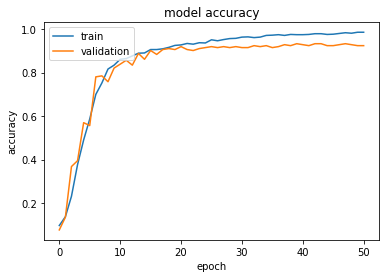

Accuracy: 91.42%
Baseline Error: 8.58%


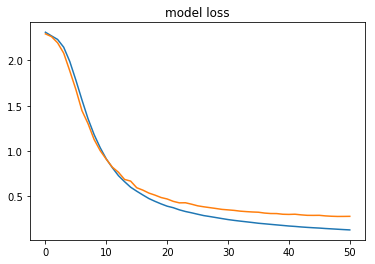

In [26]:
# BUILDING MODEL WITH 100 INPUT HIDDEN LAYERS FOR EPOCH COUNT
model_epochcount100 = get_model_epochcheck(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

#### EPOCH = 51( hidden layer=100)

### 1e. Is there any evidence that any of your networks overfit to the training data? If so, what is the evidence?


Answer:


    As we can see again from the epoch graphs, train data and validation data lines(blue and orange) are almost close to each other,are in sync and aligns with each other too. There isnot much gap between those two lines. 
    Also, if we check accuracies of train and test data , they are almost at sweet spot . There isnot huge difference between accuracies of train and test data. 
    So , it is safe to say that any of the networks doesnot overfit the training data
    


# PART 2

In [27]:
#SPLITTING THE TRAIN DATA INTO QUARTER OF TOTAL DATA SIZE
# USING STRATIFY = Y FOR BALANCING THE DATASET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, stratify=y,random_state=5)

In [28]:
#CALCULATING NO. OF ROWS PRESENT IN TEST DATA TO BE USED IN CONFUSION MATRIX
y_testrows = y_test.shape[0]


print(y_testrows)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

1195
(398, 256)
(398, 10)
(1195, 256)
(1195, 10)


In [29]:
#converting into list of values 
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

##### BUILDING MODEL WITH QUARTER TRAIN DATA

100
Train on 318 samples, validate on 80 samples
Epoch 1/50
318/318 [==============================] - ETA: 6s - loss: 2.4087 - acc: 0.187 - 1s 3ms/step - loss: 2.3422 - acc: 0.1006 - val_loss: 2.2965 - val_acc: 0.1000
Epoch 2/50
318/318 [==============================] - ETA: 0s - loss: 2.2843 - acc: 0.125 - 0s 163us/step - loss: 2.2995 - acc: 0.1006 - val_loss: 2.3049 - val_acc: 0.0875
Epoch 3/50
318/318 [==============================] - ETA: 0s - loss: 2.2723 - acc: 0.187 - 0s 156us/step - loss: 2.2814 - acc: 0.1069 - val_loss: 2.3013 - val_acc: 0.0750
Epoch 4/50
318/318 [==============================] - ETA: 0s - loss: 2.2768 - acc: 0.062 - 0s 181us/step - loss: 2.2693 - acc: 0.1069 - val_loss: 2.2977 - val_acc: 0.0625
Epoch 5/50
318/318 [==============================] - ETA: 0s - loss: 2.2550 - acc: 0.187 - 0s 157us/step - loss: 2.2575 - acc: 0.1509 - val_loss: 2.2860 - val_acc: 0.0500
Epoch 6/50
318/318 [==============================] - ETA: 0s - loss: 2.2028 - acc: 0.093 - 0

318/318 [==============================] - ETA: 0s - loss: 0.3569 - acc: 0.968 - 0s 167us/step - loss: 0.3622 - acc: 0.9591 - val_loss: 0.6442 - val_acc: 0.8125
Epoch 49/50
318/318 [==============================] - ETA: 0s - loss: 0.3447 - acc: 1.000 - 0s 182us/step - loss: 0.3475 - acc: 0.9623 - val_loss: 0.6201 - val_acc: 0.8375
Epoch 50/50
318/318 [==============================] - ETA: 0s - loss: 0.3373 - acc: 0.937 - 0s 145us/step - loss: 0.3408 - acc: 0.9654 - val_loss: 0.6085 - val_acc: 0.8375
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


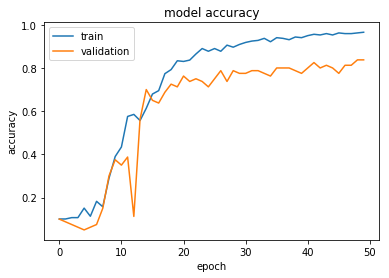

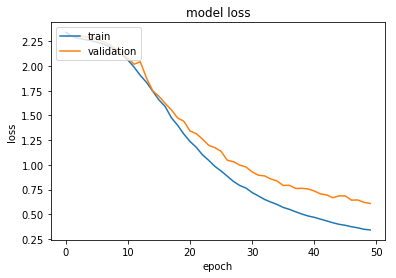

Accuracy: 87.62%
Baseline Error: 12.38%


In [30]:
# BUILDING MODEL WITH QUARTER TRAIN DATA
model_Qtrain = get_model_main(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

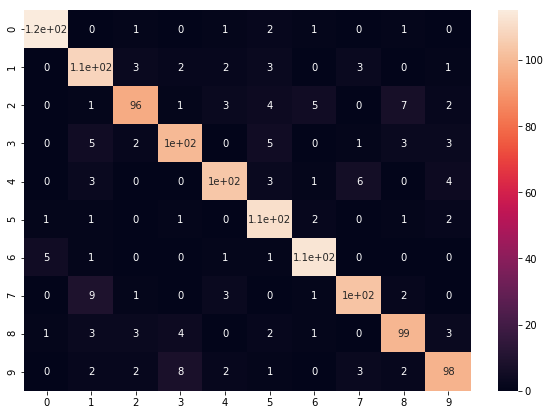

In [31]:
# CONFUSION MATRIX OF MODEL WITH 20 INPUT HIDDEN LAYERS
confusion_function(model_Qtrain,X_test,y_test)

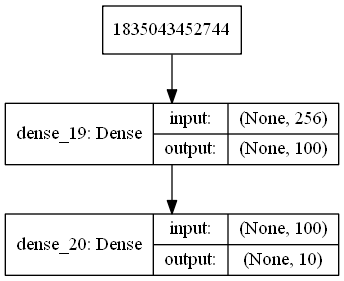

In [32]:
#PLOT OF NEURAL NETWORK GRAPH
model_plot(model_Qtrain)

100
Train on 398 samples, validate on 1195 samples
Epoch 1/50
398/398 [==============================] - ETA: 9s - loss: 2.3527 - acc: 0.093 - 1s 3ms/step - loss: 2.3163 - acc: 0.0905 - val_loss: 2.3047 - val_acc: 0.0895
Epoch 2/50
398/398 [==============================] - ETA: 0s - loss: 2.2943 - acc: 0.093 - ETA: 0s - loss: 2.3023 - acc: 0.085 - 0s 358us/step - loss: 2.3040 - acc: 0.0879 - val_loss: 2.2988 - val_acc: 0.0962
Epoch 3/50
398/398 [==============================] - ETA: 0s - loss: 2.3026 - acc: 0.093 - ETA: 0s - loss: 2.2999 - acc: 0.078 - 0s 349us/step - loss: 2.2983 - acc: 0.0930 - val_loss: 2.2954 - val_acc: 0.1088
Epoch 4/50
398/398 [==============================] - ETA: 0s - loss: 2.2744 - acc: 0.156 - 0s 293us/step - loss: 2.2948 - acc: 0.1080 - val_loss: 2.2916 - val_acc: 0.1130
Epoch 5/50
398/398 [==============================] - ETA: 0s - loss: 2.2879 - acc: 0.125 - 0s 301us/step - loss: 2.2909 - acc: 0.1156 - val_loss: 2.2878 - val_acc: 0.1255
Epoch 6/50
398/

398/398 [==============================] - ETA: 0s - loss: 0.4475 - acc: 0.937 - ETA: 0s - loss: 0.3996 - acc: 0.945 - 0s 389us/step - loss: 0.3984 - acc: 0.9422 - val_loss: 0.5615 - val_acc: 0.8678
Epoch 45/50
398/398 [==============================] - ETA: 0s - loss: 0.4642 - acc: 0.875 - ETA: 0s - loss: 0.3751 - acc: 0.956 - 0s 391us/step - loss: 0.3809 - acc: 0.9497 - val_loss: 0.5614 - val_acc: 0.8603
Epoch 46/50
398/398 [==============================] - ETA: 0s - loss: 0.3296 - acc: 0.968 - ETA: 0s - loss: 0.3715 - acc: 0.950 - 0s 370us/step - loss: 0.3708 - acc: 0.9523 - val_loss: 0.5460 - val_acc: 0.8695
Epoch 47/50
398/398 [==============================] - ETA: 0s - loss: 0.2941 - acc: 0.968 - ETA: 0s - loss: 0.3566 - acc: 0.947 - 0s 396us/step - loss: 0.3583 - acc: 0.9472 - val_loss: 0.5251 - val_acc: 0.8695
Epoch 48/50
398/398 [==============================] - ETA: 0s - loss: 0.3473 - acc: 0.937 - ETA: 0s - loss: 0.3327 - acc: 0.960 - 0s 386us/step - loss: 0.3431 - acc: 0

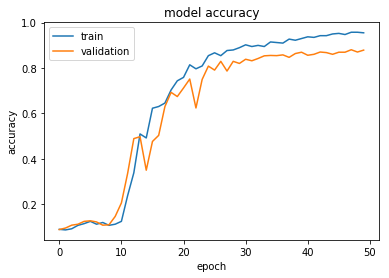

Accuracy: 87.87%
Baseline Error: 12.13%


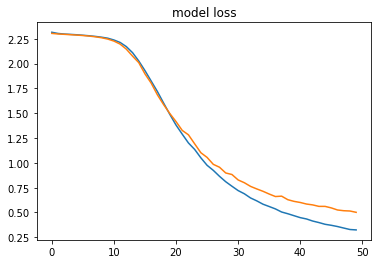

In [33]:
# BUILDING QUARTER MODEL WITH TEST DATA AND PLOTTING EPOCH GRAPH 
model_qtest = get_model_testdata(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

100
Train on 318 samples, validate on 80 samples
Epoch 1/300
318/318 [==============================] - ETA: 7s - loss: 2.2997 - acc: 0.062 - 1s 3ms/step - loss: 2.3149 - acc: 0.0786 - val_loss: 2.3081 - val_acc: 0.1750
Epoch 2/300
318/318 [==============================] - ETA: 0s - loss: 2.2977 - acc: 0.062 - 0s 165us/step - loss: 2.3058 - acc: 0.0786 - val_loss: 2.3005 - val_acc: 0.1750
Epoch 3/300
318/318 [==============================] - ETA: 0s - loss: 2.2685 - acc: 0.187 - 0s 152us/step - loss: 2.2993 - acc: 0.0818 - val_loss: 2.2954 - val_acc: 0.1625
Epoch 4/300
318/318 [==============================] - ETA: 0s - loss: 2.2740 - acc: 0.093 - 0s 178us/step - loss: 2.2939 - acc: 0.0786 - val_loss: 2.2916 - val_acc: 0.1625
Epoch 5/300
318/318 [==============================] - ETA: 0s - loss: 2.2975 - acc: 0.031 - 0s 152us/step - loss: 2.2893 - acc: 0.0818 - val_loss: 2.2877 - val_acc: 0.1625
Epoch 6/300
318/318 [==============================] - ETA: 0s - loss: 2.2888 - acc: 0.0

Epoch 48/300
318/318 [==============================] - ETA: 0s - loss: 0.4789 - acc: 0.906 - 0s 147us/step - loss: 0.4656 - acc: 0.9497 - val_loss: 0.7209 - val_acc: 0.8500
Epoch 49/300
318/318 [==============================] - ETA: 0s - loss: 0.5264 - acc: 0.937 - 0s 171us/step - loss: 0.4495 - acc: 0.9623 - val_loss: 0.7144 - val_acc: 0.8250
Epoch 50/300
318/318 [==============================] - ETA: 0s - loss: 0.3890 - acc: 1.000 - 0s 155us/step - loss: 0.4352 - acc: 0.9528 - val_loss: 0.6805 - val_acc: 0.8500
Epoch 51/300
318/318 [==============================] - ETA: 0s - loss: 0.4061 - acc: 0.968 - 0s 149us/step - loss: 0.4237 - acc: 0.9528 - val_loss: 0.6939 - val_acc: 0.8125
Epoch 52/300
318/318 [==============================] - ETA: 0s - loss: 0.3738 - acc: 0.968 - ETA: 0s - loss: 0.4108 - acc: 0.955 - 0s 291us/step - loss: 0.4068 - acc: 0.9560 - val_loss: 0.6681 - val_acc: 0.8500
Epoch 53/300
318/318 [==============================] - ETA: 0s - loss: 0.3779 - acc: 0.968 

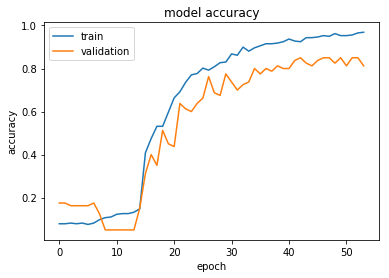

Accuracy: 85.44%
Baseline Error: 14.56%


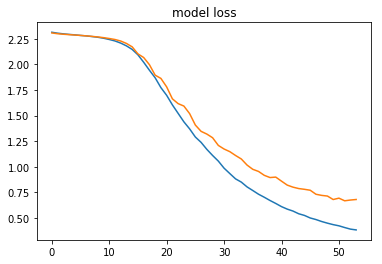

In [34]:
# BUILDING MODEL WITH QUARTER DATA FOR EPOCH COUNT
model_Hepochcount= get_model_epochcheck(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

#### EPOCH = 54( QUARTER DATA)

### SPLITTING THE TRAIN DATA INTO HALF OF TOTAL DATA SIZE

In [35]:
#SPLITTING THE TRAIN DATA INTO QUARTER OF TOTAL DATA SIZE
# USING STRATIFY = Y FOR BALANCING THE DATASET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y,random_state=5)

In [36]:
#CALCULATING NO. OF ROWS PRESENT IN TEST DATA TO BE USED IN CONFUSION MATRIX
y_testrows = y_test.shape[0]


print(y_testrows)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

797
(796, 256)
(796, 10)
(797, 256)
(797, 10)


In [37]:
#converting into list of values 
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

##### BUILDING MODEL WITH HALF TRAIN DATA

100
Train on 636 samples, validate on 160 samples
Epoch 1/50
636/636 [==============================] - ETA: 15s - loss: 2.3679 - acc: 0.0000e+ - ETA: 0s - loss: 2.3199 - acc: 0.0911     - 1s 2ms/step - loss: 2.3134 - acc: 0.1006 - val_loss: 2.2957 - val_acc: 0.1187
Epoch 2/50
636/636 [==============================] - ETA: 0s - loss: 2.2920 - acc: 0.125 - ETA: 0s - loss: 2.2963 - acc: 0.106 - 0s 165us/step - loss: 2.2891 - acc: 0.1069 - val_loss: 2.2863 - val_acc: 0.1187
Epoch 3/50
636/636 [==============================] - ETA: 0s - loss: 2.2693 - acc: 0.156 - ETA: 0s - loss: 2.2741 - acc: 0.080 - 0s 172us/step - loss: 2.2734 - acc: 0.0770 - val_loss: 2.2706 - val_acc: 0.0875
Epoch 4/50
636/636 [==============================] - ETA: 0s - loss: 2.2664 - acc: 0.093 - ETA: 0s - loss: 2.2566 - acc: 0.110 - 0s 171us/step - loss: 2.2508 - acc: 0.1321 - val_loss: 2.2435 - val_acc: 0.0813
Epoch 5/50
636/636 [==============================] - ETA: 0s - loss: 2.2386 - acc: 0.062 - ETA: 0s - l

636/636 [==============================] - ETA: 0s - loss: 0.3291 - acc: 0.937 - ETA: 0s - loss: 0.2364 - acc: 0.971 - 0s 168us/step - loss: 0.2372 - acc: 0.9733 - val_loss: 0.3641 - val_acc: 0.9250
Epoch 40/50
636/636 [==============================] - ETA: 0s - loss: 0.2492 - acc: 1.000 - ETA: 0s - loss: 0.2398 - acc: 0.973 - 0s 160us/step - loss: 0.2296 - acc: 0.9748 - val_loss: 0.3548 - val_acc: 0.9313
Epoch 41/50
636/636 [==============================] - ETA: 0s - loss: 0.1452 - acc: 1.000 - ETA: 0s - loss: 0.2043 - acc: 0.983 - 0s 171us/step - loss: 0.2222 - acc: 0.9764 - val_loss: 0.3548 - val_acc: 0.9187
Epoch 42/50
636/636 [==============================] - ETA: 0s - loss: 0.1540 - acc: 1.000 - ETA: 0s - loss: 0.2057 - acc: 0.978 - 0s 161us/step - loss: 0.2146 - acc: 0.9780 - val_loss: 0.3494 - val_acc: 0.9187
Epoch 43/50
636/636 [==============================] - ETA: 0s - loss: 0.1845 - acc: 1.000 - ETA: 0s - loss: 0.2058 - acc: 0.984 - 0s 171us/step - loss: 0.2076 - acc: 0

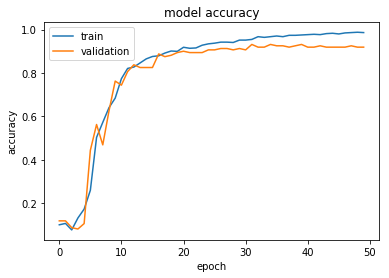

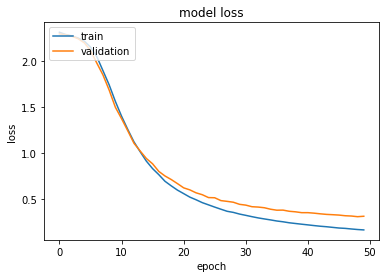

Accuracy: 89.08%
Baseline Error: 10.92%


In [38]:
# BUILDING MODEL WITH HALF TRAIN DATA
model_Htrain = get_model_main(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

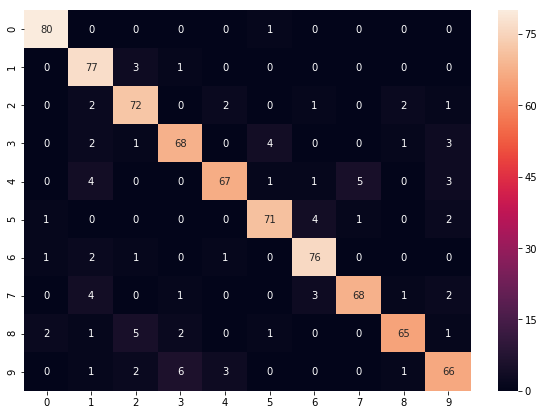

In [39]:
# CONFUSION MATRIX OF MODEL WITH 20 INPUT HIDDEN LAYERS
confusion_function(model_Htrain,X_test,y_test)

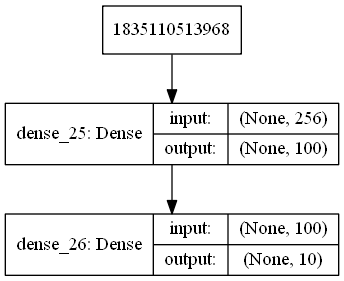

In [40]:
#PLOT OF NEURAL NETWORK GRAPH
model_plot(model_Htrain)

100
Train on 796 samples, validate on 797 samples
Epoch 1/50
796/796 [==============================] - ETA: 19s - loss: 2.3199 - acc: 0.15 - ETA: 0s - loss: 2.3165 - acc: 0.1034 - ETA: 0s - loss: 2.3089 - acc: 0.108 - 1s 1ms/step - loss: 2.3078 - acc: 0.1093 - val_loss: 2.2959 - val_acc: 0.1167
Epoch 2/50
796/796 [==============================] - ETA: 0s - loss: 2.3137 - acc: 0.062 - ETA: 0s - loss: 2.2972 - acc: 0.099 - ETA: 0s - loss: 2.2943 - acc: 0.110 - 0s 227us/step - loss: 2.2935 - acc: 0.1118 - val_loss: 2.2846 - val_acc: 0.1305
Epoch 3/50
796/796 [==============================] - ETA: 0s - loss: 2.2972 - acc: 0.187 - ETA: 0s - loss: 2.2819 - acc: 0.132 - ETA: 0s - loss: 2.2807 - acc: 0.129 - 0s 227us/step - loss: 2.2808 - acc: 0.1307 - val_loss: 2.2709 - val_acc: 0.1631
Epoch 4/50
796/796 [==============================] - ETA: 0s - loss: 2.2750 - acc: 0.062 - ETA: 0s - loss: 2.2694 - acc: 0.145 - ETA: 0s - loss: 2.2651 - acc: 0.130 - 0s 213us/step - loss: 2.2635 - acc: 0.1

796/796 [==============================] - ETA: 0s - loss: 0.2417 - acc: 1.000 - ETA: 0s - loss: 0.2426 - acc: 0.972 - ETA: 0s - loss: 0.2441 - acc: 0.972 - 0s 259us/step - loss: 0.2504 - acc: 0.9648 - val_loss: 0.3956 - val_acc: 0.8908
Epoch 34/50
796/796 [==============================] - ETA: 0s - loss: 0.2552 - acc: 0.968 - ETA: 0s - loss: 0.2541 - acc: 0.963 - ETA: 0s - loss: 0.2424 - acc: 0.968 - 0s 237us/step - loss: 0.2404 - acc: 0.9686 - val_loss: 0.3884 - val_acc: 0.8883
Epoch 35/50
796/796 [==============================] - ETA: 0s - loss: 0.1953 - acc: 1.000 - ETA: 0s - loss: 0.2268 - acc: 0.965 - ETA: 0s - loss: 0.2365 - acc: 0.967 - 0s 243us/step - loss: 0.2317 - acc: 0.9686 - val_loss: 0.3836 - val_acc: 0.8971
Epoch 36/50
796/796 [==============================] - ETA: 0s - loss: 0.2122 - acc: 1.000 - ETA: 0s - loss: 0.2111 - acc: 0.981 - ETA: 0s - loss: 0.2140 - acc: 0.976 - 0s 231us/step - loss: 0.2213 - acc: 0.9724 - val_loss: 0.3785 - val_acc: 0.8896
Epoch 37/50
796/

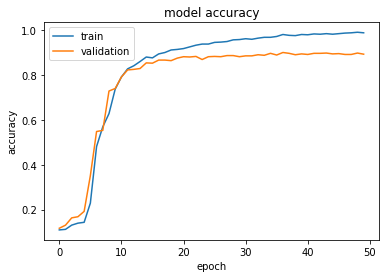

Accuracy: 89.34%
Baseline Error: 10.66%


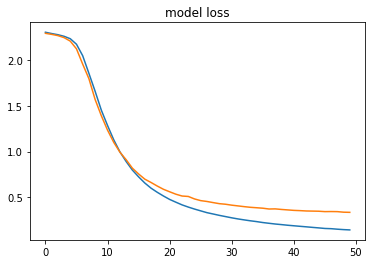

In [41]:
# BUILDING half MODEL WITH TEST DATA AND PLOTTING EPOCH GRAPH 
model_htest = get_model_testdata(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

100
Train on 636 samples, validate on 160 samples
Epoch 1/300
636/636 [==============================] - ETA: 18s - loss: 2.3358 - acc: 0.12 - ETA: 0s - loss: 2.3159 - acc: 0.0938 - 1s 2ms/step - loss: 2.3091 - acc: 0.0959 - val_loss: 2.2804 - val_acc: 0.1187
Epoch 2/300
636/636 [==============================] - ETA: 0s - loss: 2.2847 - acc: 0.062 - ETA: 0s - loss: 2.2795 - acc: 0.101 - 0s 163us/step - loss: 2.2801 - acc: 0.0959 - val_loss: 2.2724 - val_acc: 0.1187
Epoch 3/300
636/636 [==============================] - ETA: 0s - loss: 2.2697 - acc: 0.093 - ETA: 0s - loss: 2.2687 - acc: 0.096 - 0s 185us/step - loss: 2.2645 - acc: 0.0959 - val_loss: 2.2546 - val_acc: 0.1187
Epoch 4/300
636/636 [==============================] - ETA: 0s - loss: 2.2825 - acc: 0.0000e+0 - ETA: 0s - loss: 2.2477 - acc: 0.1000    - ETA: 0s - loss: 2.2421 - acc: 0.097 - 0s 217us/step - loss: 2.2415 - acc: 0.0959 - val_loss: 2.2271 - val_acc: 0.1187
Epoch 5/300
636/636 [==============================] - ETA: 0

636/636 [==============================] - ETA: 0s - loss: 0.2311 - acc: 0.968 - ETA: 0s - loss: 0.2378 - acc: 0.978 - ETA: 0s - loss: 0.2578 - acc: 0.968 - 0s 218us/step - loss: 0.2567 - acc: 0.9686 - val_loss: 0.3653 - val_acc: 0.9125
Epoch 38/300
636/636 [==============================] - ETA: 0s - loss: 0.3109 - acc: 0.968 - ETA: 0s - loss: 0.2470 - acc: 0.971 - 0s 191us/step - loss: 0.2454 - acc: 0.9717 - val_loss: 0.3618 - val_acc: 0.9062
Epoch 39/300
636/636 [==============================] - ETA: 0s - loss: 0.2651 - acc: 0.968 - ETA: 0s - loss: 0.2260 - acc: 0.983 - 0s 179us/step - loss: 0.2360 - acc: 0.9733 - val_loss: 0.3524 - val_acc: 0.9125
Epoch 40/300
636/636 [==============================] - ETA: 0s - loss: 0.2240 - acc: 0.937 - ETA: 0s - loss: 0.2273 - acc: 0.980 - 0s 175us/step - loss: 0.2279 - acc: 0.9764 - val_loss: 0.3501 - val_acc: 0.9062
Epoch 41/300
636/636 [==============================] - ETA: 0s - loss: 0.2404 - acc: 1.000 - ETA: 0s - loss: 0.2380 - acc: 0.9

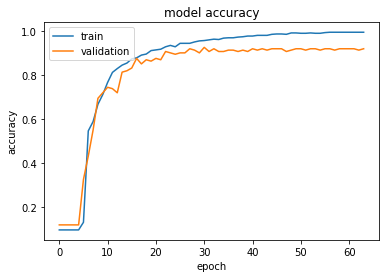

Accuracy: 89.71%
Baseline Error: 10.29%


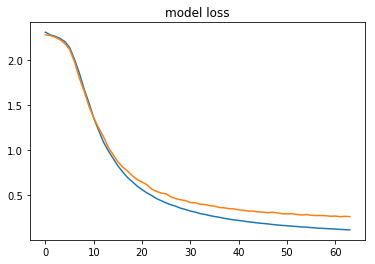

In [42]:
# BUILDING MODEL WITH HALF DATA FOR EPOCH COUNT
model_Hepochcount= get_model_epochcheck(X_train,y_train, X_test, y_test,
                                  input_layer=100,
                                  output_layer=10,
                                  input_shape=256,
                                  activation_func='sigmoid',
                                  loss_func='categorical_crossentropy',
                                  optmzr_func=my_optimizer)

#### EPOCH = 64( half data)

#####  2a. Conduct experiments by fixing your number of hidden units to 100. Instead of using all of the training examples, train two networks, using respectively one quarter and one half of the training examples for training. Make sure that in each case your training data is approximately balanced among the 10 different classes. Train your network for 50 epochs. After each epoch, record your accuracy on training set AND test set for your network. After training is complete, create a confusion matrix for each of your trained networks, summarizing results on the test set.

Answer:
 After splitting the data into training and test data( Quarterly and half) , I am running the model using function get_model_main() that I created earlier. I have also passed argument 'Stratify = Y ' to balance the dataset with having same proportion of train and test data. This model will further split the train data into train and validation data. I am not using test data to fit my model because it will cause data leakage issue. 
 
 1. Dividing train data into quarter , we get test accuracy of 87.62%. After creating confusion matrix, I found that few digits such as digit 9 were falsely predicted as 3 , digit 7 was falsely predicted as 1.
 2. Setting input layer equals to 20 , we get test accuracy of 89.08%. After creating confusion matrix, I found that few digits such as digit 9 was falsely predicted as 3, 8 as 2 and 4 as 7.


##### 2b. Give a plot of both training and test accuracy as a function of epoch number
(graph both of these on sample plot).


Answer: 
Since this question asks to plot training and test data accuracies as function of epoch number, I created another function get_model_testdata() which uses test data as validation data and it will plot epoch graphs for hidden layers equals to 20,50 and 100 respectively.

##### 2c. Discuss your results. How does size of training data affect the final accuracy on the test data?

Answer:

Yes, size of the training data affects accuracy.With decent sized training data, we can build complex/sophisticated models. Also, we do see here that accuracy improves by almost 1.5% when we increased the size of training data.

##### 2d. Discuss your results. How does size of training data affect number of epochs needed for training to converge?

Answer: 



We can check this by understanding epoch graphs of different models we plotted above. As we can see from the graph, when we increase train data size, the network model would have to train more data and this would caused epoch count to increase.


I also created function to check no. of epochs needed with above two dataset sizes (Quarter and Half). For this, I gave epochs =300 and set early stopping criteria with patience =2.

 When I had quarter data size( 318 samples), it took 54 epochs to converge but when I had half data size( 636 samples), it took 64 epochs to converge. After doubling the dataset size, epoch increased by only 19%. 

### 1e. Is there any evidence that any of your networks overfit to the training data? If so, what is the evidence?


Answer:


    As we can see again from the epoch graphs, train data and validation data lines(blue and orange) are NOT THAT CLOSE to each other. There is a gap between those two lines. 
    Also, if we check accuracies of train and test data , we find that networks are overfitting the test data . Training data accuracy is in nineties while test data accuracy is in eighties. There is a difference between accuracies of train and test data. 

    

# PART THREE: OPTIMIZATION

###### Here, I am using HYPERAS  library to tune the hyper-parameters so as to get the best architecture in order to achieve the best possible result with the architecture. I have specified several hyper-parameters that are to be optimized by Hyperas. I have enclosed any such search spaces with curly braces which is how Hyperopt will identify what to tune.

In [43]:
# split into input (X) and output (Y) variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=991989)
y_testrows = y_test.shape[0]
print(y_testrows)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#converting into list of values 
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

478
(1115, 256)
(1115, 10)
(478, 256)
(478, 10)


In [44]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
def data():
    df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data", delimiter = r"\s+",
                header=None )
    #Loading predictors in X
    X = pd.DataFrame(df)
    #Dropping Target ttributes
    X = X.drop([256,257,258,259,260,261,262,263,264,265], axis=1)
    #Loading target attributes in y
    y = pd.DataFrame(df.iloc[:,[256,257,258,259,260,261,262,263,264,265]])
    #Renaming labels of target attributes
    y.rename(columns={256:0, 257:1, 258:2, 259:3, 260:4, 261:5, 262:6, 263:7, 264:8, 265:9 }, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
    
    #converting into list of values 
    X_train = X_train.values
    y_train = y_train.values
    X_test = X_test.values
    y_test = y_test.values
    return X_train, y_train, X_test, y_test

In [45]:
#Source: 
#https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b
#https://dzubo.github.io/machine-learning/2017/05/25/increasing-model-accuracy-by-tuning-parameters.html
#https://github.com/maxpumperla/hyperas


def model(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense({{choice([32,64,128,200])}}, input_shape=(256,)))
    model.add(Activation({{choice(['relu', 'tanh', 'sigmoid', 'hard_sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    #model.add(Dense({{choice([32,50,64,75,100,128,200])}}))
    #model.add(Activation({{choice(['softmax', 'softplus', 'softsign', 'tanh', 'sigmoid', 'hard_sigmoid'])}}))
    #model.add(Dropout({{uniform(0, 1)}}))
    
    if {{choice(['one', 'two'])}} == 'two':
        model.add(Dense({{choice([32,64,128,200])}}))
        model.add(Activation({{choice(['relu', 'tanh', 'sigmoid', 'hard_sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(10))
    model.add(Activation({{choice(['sigmoid','softmax'])}}))
    adam = Adam(lr={{choice([50**-3, 50**-2, 50**-1])}})
    sgd = SGD(lr={{choice([50**-3, 50**-2, 50**-1])}})
   
    choiceval = {{choice(['sgd', 'adam' ])}}
    if choiceval == 'adam':
        optim = adam
    else:
        optim = sgd
        
    model.compile(loss={{choice(['categorical_crossentropy', 'binary_crossentropy' ,'categorical_hinge'])}}, metrics=['accuracy'],optimizer=optim)
  # 
#    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(X_train, y_train,
              batch_size={{choice([128,256,512])}},
              nb_epoch=150,
              verbose=0,
              validation_split=0.2)
#              validation_data=(X_test, y_test))
    score, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [48]:
X_train, y_train, X_test, y_test = data()

best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          eval_space=True,
                                          notebook_name='assignment4_digits')





                                     

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.image as mpimg
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    import itertools
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Flatten, Activation
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator
except:
    pass

try:
    from keras.optimizers import SGD, Adam
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from sklearn.metrics imp

C:\Users\purwa\AML\temp_model.py:165: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Test accuracy:                                     
0.7489539738978302                                 
Test accuracy:                                                               
0.6043933131205985                                                           
Test accuracy:                                                               
0.07949790838622647                                                          
Test accuracy:                                                               
0.9822175732217573                                                           
Test accuracy:                                                               
0.9351464417689016                                                           
100%|██████████| 5/5 [00:37<00:00,  7.68s/it, best loss: -0.9822175732217573]


In [49]:
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, y_test))


Evalutation of best performing model:
478/478 [==============================] - ETA:  - 0s 100us/step
[0.04577924962697169, 0.9822175732217573]


In [50]:
print("Best performing model chosen hyper-parameters:")
print(best_run)

Best performing model chosen hyper-parameters:
{'Activation': 'tanh', 'Activation_1': 'softplus', 'Activation_2': 'hard_sigmoid', 'Activation_3': 'softmax', 'Dense': 200, 'Dense_1': 50, 'Dense_2': 64, 'Dropout': 0.12064860770171626, 'Dropout_1': 0.1602501347478713, 'Dropout_2': 'one', 'Dropout_3': 0.7646166765488501, 'batch_size': 512, 'choiceval': 'adam', 'loss': 'binary_crossentropy', 'lr': 0.0004, 'lr_1': 0.0004}


###### So, the model above gave us the accuracy of 98% . Here, hyperas optimizer used binary_crossentropy to acheive that.

In [51]:
#Source: 
#https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b
#https://dzubo.github.io/machine-learning/2017/05/25/increasing-model-accuracy-by-tuning-parameters.html
#https://github.com/maxpumperla/hyperas


def model_withoutbinary(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense({{choice([32,64,128,200])}}, input_shape=(256,)))
    model.add(Activation({{choice(['relu', 'tanh', 'sigmoid', 'hard_sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    #model.add(Dense({{choice([32,50,64,75,100,128,200])}}))
    #model.add(Activation({{choice(['softmax', 'softplus', 'softsign', 'tanh', 'sigmoid', 'hard_sigmoid'])}}))
    #model.add(Dropout({{uniform(0, 1)}}))
    
    if {{choice(['one', 'two'])}} == 'two':
        model.add(Dense({{choice([32,64,128,200])}}))
        model.add(Activation({{choice(['relu', 'tanh', 'sigmoid', 'hard_sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(10))
    model.add(Activation({{choice(['sigmoid','softmax'])}}))
    adam = Adam(lr={{choice([50**-3, 50**-2, 50**-1])}})
    sgd = SGD(lr={{choice([50**-3, 50**-2, 50**-1])}})
   
    choiceval = {{choice(['sgd', 'adam' ])}}
    if choiceval == 'adam':
        optim = adam
    else:
        optim = sgd
        
    model.compile(loss={{choice(['categorical_crossentropy' ,'categorical_hinge'])}}, metrics=['accuracy'],optimizer=optim)
  # 
#    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(X_train, y_train,
              batch_size={{choice([128,256,512])}},
              nb_epoch=150,
              verbose=0,
              validation_split=0.2)
#              validation_data=(X_test, y_test))
    score, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [52]:
X_train, y_train, X_test, y_test = data()

best_run, best_model = optim.minimize(model=model_withoutbinary,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          eval_space=True,
                                          notebook_name='assignment4_digits')




>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.image as mpimg
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    import itertools
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Flatten, Activation
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator
except:
    pass

try:
    from keras.optimizers import SGD, Adam
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from sklearn.metrics imp

C:\Users\purwa\AML\temp_model.py:165: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Test accuracy:                                     
0.7824267789908533                                 
Test accuracy:                                                               
0.0857740587956237                                                           
Test accuracy:                                                               
0.2594142261284665                                                           
Test accuracy:                                                               
0.9079497912937627                                                           
Test accuracy:                                                               
0.920502092299601                                                            
100%|██████████| 5/5 [00:43<00:00,  8.87s/it, best loss: -0.920502092299601] 


In [53]:
print("Evaluation of best performing model:")
print(best_model.evaluate(X_test, y_test))


Evaluation of best performing model:
478/478 [==============================] - ETA:  - 0s 100us/step
[0.1605713932958108, 0.920502092299601]


In [54]:
print("Best performing model chosen hyper-parameters:")
print(best_run)

Best performing model chosen hyper-parameters:
{'Activation': 'tanh', 'Activation_1': 'softsign', 'Activation_2': 'sigmoid', 'Activation_3': 'softmax', 'Dense': 128, 'Dense_1': 128, 'Dense_2': 64, 'Dropout': 0.8364280725819752, 'Dropout_1': 0.9532739136720357, 'Dropout_2': 'one', 'Dropout_3': 0.03323327852409652, 'batch_size': 512, 'choiceval': 'adam', 'loss': 'categorical_hinge', 'lr': 0.02, 'lr_1': 8e-06}


#### without using binary cross entropy , hyperas optimizer gave us the accuracy of 92%.

# Extra Resources

https://github.com/abhishekchhibber/Handwritten-digit-Recognition-through-Machine-Learning/blob/master/Handwritten%20digit%20Recognition%20through%20Machine%20Learning.ipynb
https://www.kaggle.com/loveunk/kaggle-digit-recognizer-keras-cnn-100-accuracy
https://www.kaggle.com/mridul02/digit-recognizer-cnn-keras
https://www.kaggle.com/hs39ma/kaggle-digit-recognizer-and-keras-cnn-convol
https://www.kaggle.com/mailyousufkhan/digit-recognizer-keras-cnn
https://www.kaggle.com/parth05rohilla/mnist-digit-recognizer-using-keras-top-7
https://www.kaggle.com/ramprasad273/digit-recognizer-using-keras-with-99-65
https://www.kaggle.com/dimitreoliveira/simple-keras-and-deep-learning-digit-recognizer
https://datascienceplus.com/handwritten-digit-recognition-with-cnn/
http://dataaspirant.com/2017/05/03/handwritten-digits-recognition-tensorflow-python/
https://github.com/tentone/SemeionNet/blob/5f0621cbc443215a16b696b6e88cf9997c0d8f9b/source/semeion.py
https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-4
https://dzubo.github.io/keras/2017/04/21/tutorial-on-using-keras-for-digits-recognition.html
    